# Posterior Inference & Prediction

### Goals 
- **Establish the theoretical foundations for the three posterior analysis tasks**: estimation, hypothesis testing, and prediction.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta, binom, gamma, uniform, poisson, norm
from empiricaldist import Pmf

import utils as ut

Imagine you find yourself standing at the Museum of Modern Art (MoMA) in New York City, captivated by the artwork in front of you. While it's clear that “modern” art doesn’t necessarily mean “new” art, an intriguing question arises:

> What are the chances that this modern artist is part of Generation X or even younger—that is, born in 1965 or later?

In this chapter, we will carry out a **Bayesian analysis** to address this question. Let $\pi$ denote the proportion of artists represented in major U.S. modern art museums who are Gen X or younger.

We begin with a vague prior belief, modeled as:
$$
\pi \sim \text{Beta}(4, 6)
$$

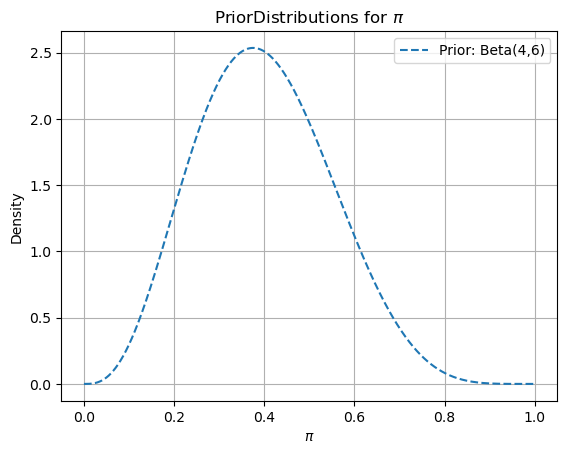

In [2]:
x = np.linspace(0, 1, 1000)
prior = beta.pdf(x, 4, 6)

plt.plot(x, prior, label='Prior: Beta(4,6)', linestyle='--')
plt.xlabel('$\pi$')
plt.ylabel('Density')
plt.title('PriorDistributions for $\pi$')
plt.legend()
plt.grid(True)
plt.show()

This prior reflects our assumption that modern art museums likely overrepresent artists born before 1965. That is, we believe $\pi$ is likely less than 0.5. After all, the modern art movement dates back to the 1880s, and gaining such artistic recognition often takes time.

To learn more about $\pi$, we examine a sample of $n = 100$ artists from the MoMA collection. This dataset, named `moma_database`, is data publicly released by MoMA (Museum of Modern Art, 2020) at [MoMA Database](https://github.com/MuseumofModernArt/collection/blob/main/Artworks.csv)

In [3]:
import re

# Path to your .txt file
file_path = 'moma_database.txt' 

df = pd.read_csv(file_path)  # Replace with actual filename

# Function to extract birth year from ArtistBio if BeginDate is missing or invalid
def extract_birth_year(bio):
    if pd.isna(bio):
        return None
    # Look for 'born XXXX' or a year at the beginning like 'American, 1930–1992'
    match = re.search(r'born\s+(\d{4})', bio)
    if match:
        return int(match.group(1))
    match_alt = re.search(r'(\d{4})\D', bio)
    if match_alt:
        return int(match_alt.group(1))
    return None

# If BeginDate is numeric and valid, use it. Otherwise, fall back to ArtistBio
df["birth_year"] = pd.to_numeric(df["BeginDate"], errors="coerce")
df["birth_year"] = df["birth_year"].fillna(df["ArtistBio"].apply(extract_birth_year))


# Create GenX column
df["GenX"] = df["birth_year"].apply(lambda x: 1 if pd.notna(x) and x >= 1965 else 0)

# Drop the columns
df.drop(columns=["Wiki QID", "ULAN","BeginDate","EndDate","birth_year"], inplace=True)

df

,ConstituentID,DisplayName,ArtistBio,Nationality,Gender,GenX
0,1,Robert Arneson,"American, 1930–1992",American,male,0
1,2,Doroteo Arnaiz,"Spanish, born 1936",Spanish,male,0
2,3,Bill Arnold,"American, born 1941",American,male,0
3,4,Charles Arnoldi,"American, born 1946",American,male,0
4,5,Per Arnoldi,"Danish, born 1941",Danish,male,0
...,...,...,...,...,...,...
15670,138858,Anastasia Samoylova,"American, born Russia, born 1984",American,NaN,1
15671,138892,Sadie Red Wing,"Indigenous, born 1990",Indigenous,female,1
15672,139075,Hanna Hur,"born 1985, Toronto, Canada, lives in New York, NY",Canadian,female,1
15673,139468,Colette and Jean-Paul Miguet,NaN,NaN,NaN,0


| Variable       | Description                                                                                   |
|----------------|-----------------------------------------------------------------------------------------------|
| **ConstituentID** | Unique identifier assigned to each artist in the dataset.                                     |
| **DisplayName**   | Full name of the artist or artist group.                                                     |
| **ArtistBio**     | Short biography including nationality and birth/death year (e.g., "American, 1930–1992").    |
| **Nationality**   | National or cultural identity of the artist, as recorded by MoMA.                            |
| **Gender**        | Gender identity of the artist, as perceived or recorded by MoMA staff.                       |
| **GenX**          | Indicator if the artist was born in 1965 or later: `1` = Gen X or younger, `0` = otherwise.  |


In [5]:
sample_df = df.sample(n=100, random_state=99)
genx_count = sample_df["GenX"].sum()
print(f"number of Gen X or younger artists in the sample: {genx_count}")

number of Gen X or younger artists in the sample: 14


In our sample, $Y = 14$ of the 100 artists are Gen X or younger.

Recognizing that $Y$ depends on $\pi$ through a **Binomial model**, we apply the **Beta-Binomial** framework. Specifically:

$$
Y \,|\, \pi \sim \text{Binomial}(100, \pi), \\
\pi \sim \text{Beta}(4, 6)
$$

Using Bayes' Rule, we update our beliefs in light of the observed data ($Y = 14$), resulting in the posterior distribution:

$$
\pi \,|\, Y = 14 \sim \text{Beta}(18, 92)
$$

The corresponding posterior density function is:
$$
f(\pi \,|\, Y = 14) = \frac{\Gamma(110)}{\Gamma(18)\Gamma(92)} \, \pi^{17} (1 - \pi)^{91}, \quad \text{for } \pi \in [0, 1]
$$

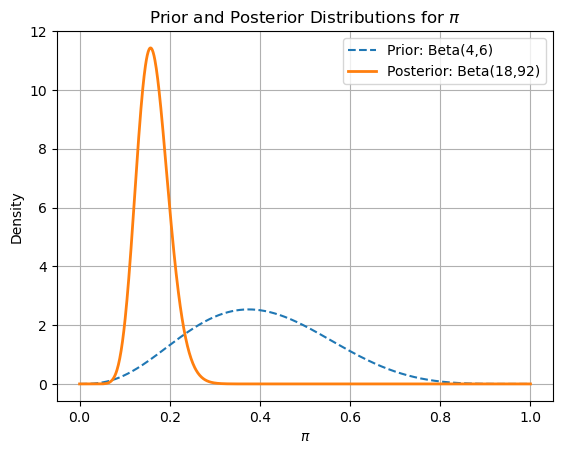

In [6]:
x = np.linspace(0, 1, 1000)
prior = beta.pdf(x, 4, 6)
posterior = beta.pdf(x, 18, 92)

plt.plot(x, prior, label='Prior: Beta(4,6)', linestyle='--')
plt.plot(x, posterior, label='Posterior: Beta(18,92)', linewidth=2)
plt.xlabel('$\pi$')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions for $\pi$')
plt.legend()
plt.grid(True)
plt.show()

This posterior distribution reflects an evolution in our understanding of $\pi$. Initially, we believed that less than half of museum artists were Gen X or younger. However, the data has moved us toward a more confident belief that this proportion is likely below 25%.

After successfully constructing the posterior, we now turn to its analysis. A complete Bayesian analysis involves three essential tasks:

1. **Estimation** – What is our best guess for $\pi$?
2. **Hypothesis Testing** – Do the data support the claim that fewer than 20% of museum artists are Gen X or younger?
3. **Prediction** – If we sample 20 additional museum artists, how many do we expect to be Gen X or younger?


# Posterior estimation

Reexamine the Beta(18, 92) posterior model for $\pi$, the proportion of modern art museum artists that are Gen X or younger. In a Bayesian analysis, we can think of this entire posterior model as an estimate of $\pi$. After all, this model of posterior plausible values provides a complete picture of the central tendency and uncertainty in $\pi$. Yet in specifying and communicating our posterior understanding, it's also useful to compute simple posterior summaries of $\pi$.

<div style="background-color:#e6d9f3; padding: 15px; border-left: 5px solid #5c2674;">
    
❓ **Quiz Yourself!**  

**What best describes your posterior estimate of $\pi$?**

a) Roughly 16% of museum artists are Gen X or younger.  
b) It's most likely the case that roughly 16% of museum artists are Gen X or younger, but that figure could plausibly be anywhere between 9% and 26%.

</div>

If you responded with answer **b**, your thinking is Bayesian in spirit.

To see why, consider next figure, which illustrates our Beta(18, 92) posterior for $\pi$ (left) alongside a different analyst's Beta(4, 16) posterior (right). This analyst started with the same Beta(4, 6) prior but only observed 10 artists, 0 of whom were Gen X or younger. Though their data yielded a different posterior, the central tendency is similar to ours. Thus, the other analyst's best guess of $\pi$ agrees with ours: roughly 16–17% of represented artists are Gen X or younger.

However, reporting only this shared “best guess” would make our two posteriors seem misleadingly similar. In fact, while we're quite confident that the representation of younger artists is between 10% and 24%, the other analyst is only willing to put that figure somewhere in the much wider range from 6% to 40%. Their relative uncertainty makes sense — they only collected 10 artworks, whereas we collected 100.

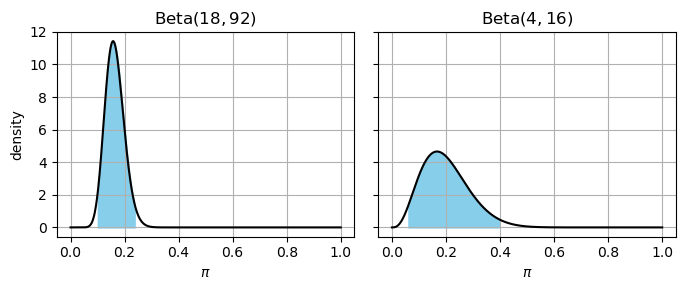

In [9]:
# Set up the distributions
x = np.linspace(0, 1, 1000)

# Our posterior: Beta(18, 92)
a1, b1 = 18, 92
y1 = beta.pdf(x, a1, b1)
ci1 = beta.ppf([0.025, 0.975], a1, b1)

# Alternative posterior: Beta(4, 16)
a2, b2 = 4, 16
y2 = beta.pdf(x, a2, b2)
ci2 = beta.ppf([0.025, 0.975], a2, b2)

# Save the figure to a file
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# Left: Beta(18, 92)
axs[0].plot(x, y1, color='black')
axs[0].fill_between(x, 0, y1, where=(x >= ci1[0]) & (x <= ci1[1]), color='skyblue')
axs[0].set_title(r'$\mathrm{Beta}(18, 92)$')
axs[0].set_xlabel(r'$\pi$')
axs[0].set_ylabel('density')
axs[0].grid(True)

# Right: Beta(4, 16)
axs[1].plot(x, y2, color='black')
axs[1].fill_between(x, 0, y2, where=(x >= ci2[0]) & (x <= ci2[1]), color='skyblue')
axs[1].set_title(r'$\mathrm{Beta}(4, 16)$')
axs[1].set_xlabel(r'$\pi$')
axs[1].grid(True)

plt.tight_layout()
plt.show()

The punchline here is that posterior estimates should reflect both the **central tendency** and **variability** in $\pi$. The **posterior mean and mode** of $\pi$ provide quick summaries of the central tendency alone. These features for our Beta(18, 92) posterior follow from the general Beta properties and match our above observation that Gen X representation is most likely around 16%:

$$
E(\pi \mid Y = 14) = \frac{18}{18 + 92} \approx 0.164
$$

$$
\text{Mode}(\pi \mid Y = 14) = \frac{18 - 1}{18 + 92 - 2} \approx 0.157
$$

Better yet, to capture **both** the central tendency and variability in $\pi$, we can report a **range** of posterior plausible $\pi$ values. This range is called a **posterior credible interval (CI)** for $\pi$. For example, we noticed earlier that the proportion of museum artists that are Gen X or younger is most likely between 10% and 24%. This range captures the more plausible values of $\pi$ while eliminating the more extreme and unlikely scenarios (Figure 8.2). In fact, 0.1 and 0.24 are the 2.5th and 97.5th **posterior percentiles** (i.e., 0.025th and 0.975th **posterior quantiles**), and thus mark the middle 95% of posterior plausible $\pi$ values.

The resulting **95% credible interval** for $\pi$, $(0.1, 0.24)$, is represented by the shaded region in the previous figure (left). Whereas the area under the entire posterior PDF is 1, the area of this shaded region — and hence the fraction of $\pi$ values that fall into this region — is 0.95. This reveals an intuitive **interpretation** of the CI. There's a 95% posterior probability that somewhere between 10% and 24% of museum artists are Gen X or younger:

$$
P(\pi \in (0.1, 0.24) \mid Y = 14) = \int_{0.1}^{0.24} f(\pi \mid y = 14)\, d\pi = 0.95
$$

Please stop for a moment. Does this interpretation feel natural and intuitive? Thus, a bit *anticlimactic*? If so, we're happy you feel that way – it means you're thinking like a Bayesian.  

In constructing the CI above, we used a “middle 95%” approach. This isn't our **only** option. The first tweak we could make is to the **95% credible level**. For example, a middle **50% CI**, ranging from the 25th to the 75th percentile, would draw our focus to a smaller range of some of the more plausible $\pi$ values. There's a 50% posterior probability that somewhere between 14% and 19% of museum artists are Gen X or younger:


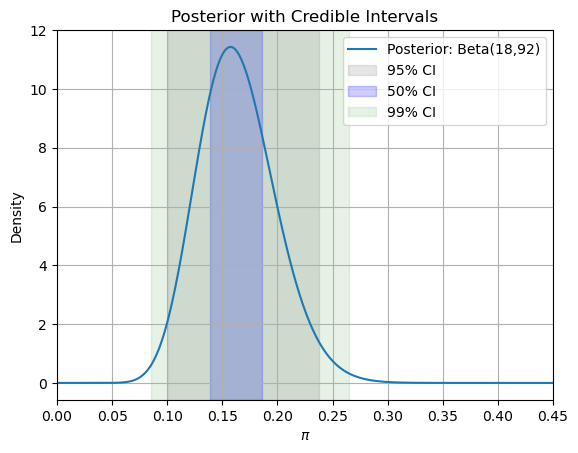

In [38]:
ci_95 = beta.ppf([0.025, 0.975], 18, 92)
ci_50 = beta.ppf([0.25, 0.75], 18, 92)
ci_99 = beta.ppf([0.005, 0.995], 18, 92)

plt.figure()
plt.plot(x, beta.pdf(x, 18, 92), label='Posterior: Beta(18,92)')
plt.axvspan(*ci_95, color='gray', alpha=0.2, label='95% CI')
plt.axvspan(*ci_50, color='blue', alpha=0.2, label='50% CI')
plt.axvspan(*ci_99, color='green', alpha=0.1, label='99% CI')
plt.xlabel('$\pi$')
plt.xlim([0,0.45])
plt.ylabel('Density')
plt.title('Posterior with Credible Intervals')
plt.legend()
plt.grid(True)
plt.show()

A second tweak to CI construction is methodological: it's not always best to report the **middle** 95% of values. The middle approach can occasionally exclude more plausible values.

A close inspection of the 50% and 95% CIs reveals this possibility. In the 95% CI, values in the upper end are less plausible than lower values (e.g., below 0.1) that were left out. If this skew were more extreme, we might prefer a **highest posterior density (HPD)** interval — one that contains the most probable values regardless of symmetry.

You’ll explore this idea in the exercises, though we won’t dwell on it here. It typically only produces meaningfully different results in cases of strong skew.

<div style="background-color:#e0e1e0; padding:10px; border:5px solid #737773;">

### Posterior Credible Intervals

Let parameter $\pi$ have posterior PDF $f(\pi\,|\,y)$. A **posterior credible interval (CI)** provides a range of plausible values for $\pi$, summarizing both central tendency and uncertainty.

For example, a middle 95% CI is given by the 2.5th and 97.5th percentiles:

$$
(\pi_{0.025}, \pi_{0.975})
$$

That is:

$$
P(\pi \in (\pi_{0.025}, \pi_{0.975})\,|\,Y = y) = \int_{\pi_{0.025}}^{\pi_{0.975}} f(\pi\,|\,y)\, d\pi = 0.95
$$
</div>



# Posterior hypothesis testing

## One-sided tests

Hypothesis testing is another common task in posterior analysis. For example, suppose we read an article claiming that fewer than 20% of museum artists are Gen X or younger. Two clues we've observed from our posterior model of $\pi$ point to this claim being at least partially plausible:

1. The majority of the posterior PDF falls below 0.2.  
2. The 95% credible interval for $\pi$, $(0.1, 0.24)$, is mostly below 0.2.

These observations are a great start. Yet we can be even more precise. To evaluate exactly how plausible it is that $\pi < 0.2$, we can calculate the **posterior probability** of this scenario, $P(\pi < 0.2 \mid Y = 14)$. 

This posterior probability is represented by the shaded area under the posterior PDF in Figure 8.4 and, mathematically, is calculated by integrating the posterior PDF on the range from 0 to 0.2:

$$
P(\pi < 0.2 \mid Y = 14) = \int_0^{0.2} f(\pi \mid y = 14)\, d\pi = 0.849
$$

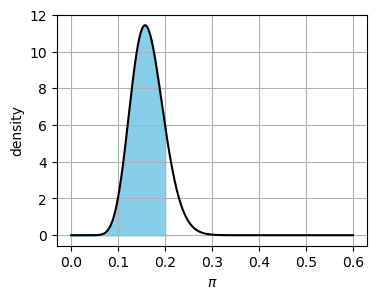

In [16]:
# Define Beta distribution parameters
a, b = 18, 92
x = np.linspace(0, 0.6, 1000)
y = beta.pdf(x, a, b)

# Define the cutoff for the shaded area
cutoff = 0.2
mask = x <= cutoff

# Create the plot
fig, ax = plt.subplots(figsize=(4, 3))

# Plot full beta pdf
ax.plot(x, y, color='black')

# Shade area under the curve for x <= 0.2
ax.fill_between(x[mask], 0, y[mask], color='skyblue')

# Labels
ax.set_xlabel(r'$\pi$')
ax.set_ylabel('density')

# Tight layout and save
plt.grid(True)
plt.show()

The result reveals strong evidence in favor of our claim: there's a roughly **84.9% posterior chance** that Gen Xers account for fewer than 20% of modern art museum artists.

This analysis of our claim is refreshingly straightforward. We simply calculated the posterior probability of the scenario of interest.

Though not always necessary, practitioners often formalize this procedure into a **hypothesis testing framework**. For example, we can frame our analysis as two competing hypotheses:

- The **null hypothesis** $H_0$ contends that **at least 20%** of museum artists are Gen X or younger (the status quo here),  
- whereas the **alternative hypothesis** $H_a$ (our claim) contends that this is not the case.

In mathematical notation:
$$
\begin{aligned}
H_0 &: \quad \pi \geq 0.2 \\
H_a &: \quad \pi < 0.2
\end{aligned}
$$

Note that $H_a$ claims that $\pi$ lies on **one side** of 0.2 ($\pi < 0.2$) as opposed to just being **different** than 0.2 ($\pi \ne 0.2$). Thus, we call this a **one-sided hypothesis test**.

We've already calculated the posterior probability of the alternative hypothesis to be $P(H_a \mid Y = 14) = 0.849$. Thus, the posterior probability of the null hypothesis is $P(H_0 \mid Y = 14) = 0.151$.

Putting these together, the **posterior odds** that $\pi < 0.2$ are roughly **5.62**. That is, our posterior assessment is that $\pi$ is nearly 6 times more likely to be **below** 0.2 than to be **above** 0.2:

$$
\text{posterior odds} = \frac{P(H_a \mid Y = 14)}{P(H_0 \mid Y = 14)} \approx 5.62
$$

Of course, these posterior odds represent our **updated** understanding of $\pi$ upon observing the survey data, $Y = 14$ of $n = 100$ sampled artists were Gen X or younger.  

*Prior* to sampling these artists, we had a much higher assessment of Gen X representation at major art museums. Specifically, the **prior probability** that $\pi < 0.2$, calculated by the area under the Beta(4, 6) **prior** PDF $f(\pi)$ that falls below 0.2, was only 0.0856:

$$
P(H_a) = \int_0^{0.2} f(\pi)\, d\pi \approx 0.0856
$$

Thus, the prior probability of the null hypothesis is $P(H_0) = 0.914$. It follows that the prior odds of Gen X representation being below 0.2 were roughly only 1 in 10:

$$
\text{Prior odds} = \frac{P(H_a)}{P(H_0)} \approx 0.093
$$

### Bayes Factor

The **Bayes Factor (BF)** compares the posterior odds to the prior odds, and hence provides insight into just how much our understanding about Gen X representation **evolved** upon observing our sample data:

$$
\text{Bayes Factor} = \frac{\text{posterior odds}}{\text{prior odds}}
$$

In our example, the Bayes Factor is roughly 60. Thus, upon observing the artwork data, the posterior odds of our hypothesis about Gen Xers are roughly **60 times higher** than the prior odds.  
Or, our confidence in this hypothesis jumped quite a bit.

We summarize the Bayes Factor below, including some guiding principles for its interpretation:

<div style="background-color:#e0e1e0; padding:10px; border:5px solid #737773;">


In a hypothesis test of two competing hypotheses, $H_a$ vs $H_0$, the **Bayes Factor** is an odds ratio for $H_a$:

$$
\text{Bayes Factor} = \frac{\text{posterior odds}}{\text{prior odds}} = \frac{P(H_a \mid Y)/P(H_0 \mid Y)}{P(H_a)/P(H_0)}
$$

As a ratio, it's meaningful to compare the Bayes Factor (BF) to 1. To this end, consider three possible scenarios:

1. **BF = 1**: The plausibility of $H_a$ *didn't change* in light of the observed data.  
2. **BF > 1**: The plausibility of $H_a$ *increased* in light of the observed data.  
   - Thus, the greater the Bayes Factor, the more convincing the evidence for $H_a$.
3. **BF < 1**: The plausibility of $H_a$ *decreased* in light of the observed data.
</div>

In [17]:
prior_prob = beta.cdf(0.2, 4, 6)
posterior_prob = beta.cdf(0.2, 18, 92)

posterior_odds = posterior_prob / (1 - posterior_prob)
prior_odds = prior_prob / (1 - prior_prob)
bayes_factor = posterior_odds / prior_odds

print(f"Prior P(π < 0.2): {prior_prob:.4f}")
print(f"Posterior P(π < 0.2): {posterior_prob:.4f}")
print(f"Posterior Odds: {posterior_odds:.2f}")
print(f"Prior Odds: {prior_odds:.2f}")
print(f"Bayes Factor: {bayes_factor:.2f}")

Prior P(π < 0.2): 0.0856
Posterior P(π < 0.2): 0.8490
Posterior Odds: 5.62
Prior Odds: 0.09
Bayes Factor: 60.02


Bringing it all together, the posterior probability (0.85) and Bayes Factor (60) establish **fairly convincing** evidence in favor of the claim that fewer than 20% of artists at major modern art museums are Gen X or younger.

Did you wince in reading that sentence? The term *“fairly convincing”* might seem a little wishy-washy. In the past, you might have learned specific cut-offs that distinguish between *“statistically significant”* and *“not statistically significant”* results, or allow you to *“reject”* or *“fail to reject”* a hypothesis. However, this practice provides false comfort. Reality is not so clear-cut.

For this reason, across the frequentist and Bayesian spectrum, the broader statistics community advocates **against** making rigid conclusions using universal rules and **for** a more nuanced practice which takes into account the context and potential implications of each individual hypothesis test. Thus, there is no magic, one-size-fits-all cut-off for what Bayes Factor or posterior probability evidence is big enough to filter claims into “true” or “false” categories.

In fact, what we have is more powerful than a binary decision — we have a holistic measure of our level of uncertainty about the claim. This level of uncertainty can inform our next steps. In our art example, do we have ample evidence for our claim? **We're convinced.**

## Two-sided tests

Especially when working in new settings, it's not always the case that we wish to test a one-directional claim about some parameter $\pi$.

For example, consider a new art researcher that simply wishes to test **whether or not 30%** of major museum artists are Gen X or younger. This hypothesis is **two-sided**:

$$
\begin{aligned}
H_0 &: \quad \pi = 0.3 \\
H_a &: \quad \pi \ne 0.3
\end{aligned}
$$

When we try to hit this two-sided hypothesis test with the same hammer we used for the one-sided hypothesis test, we quickly run into a problem. Since $\pi$ is **continuous**, the prior and posterior probabilities that $\pi$ is **exactly** 0.3 (i.e., that $H_0$ is true) are both zero.

For example, the posterior probability that $\pi = 0.3$ is calculated by the area of the **line** under the posterior PDF at 0.3. As is true for any line, this area is 0:

$$
P(\pi = 0.3 \mid Y = 14) = \int_{0.3}^{0.3} f(\pi \mid y = 14)\, d\pi = 0
$$

Thus, the posterior odds, prior odds, and consequently the Bayes factor are all undefined:

$$
\text{Posterior odds} = \frac{P(H_a \mid Y = 14)}{P(H_0 \mid Y = 14)} = \frac{1}{0} = \text{nooooo!}
$$

No problem. There's not one recipe for success. To that end, try the following quiz:

<div style="background-color:#e6d9f3; padding: 15px; border-left: 5px solid #5c2674;">
    
❓ **Quiz Yourself!**  

Recall that the 95% posterior credible interval for $\pi$ is (0.1, 0.24).  Does this CI provide ample evidence that $\pi$ differs from 0.3?

</div>

If you answered “yes,” then you intuited a reasonable approach to two-sided hypothesis testing. The hypothesized value of $\pi$ (here 0.3) is “substantially” outside the posterior credible interval, thus we have ample evidence in favor of $H_a$. The fact that 0.3 is so far above the range of plausible $\pi$ values makes us pretty confident that the proportion of museum artists that are Gen X or younger is **not** 0.3.

Yet what's “substantial” or clear in one context might be different than what's “substantial” in another. With that in mind, it is best practice to define “substantial” **ahead of time**, *before* seeing any data.

For example, in the context of artist representation, we might consider any proportion outside the 0.05 window around 0.3 to be meaningfully different from 0.3. This essentially adds a little buffer into our hypotheses — $\pi$ is either *around* 0.3 (between 0.25 and 0.35) or it’s not:

$$
\begin{aligned}
H_0 &: \quad \pi \in (0.25, 0.35) \\
H_a &: \quad \pi \notin (0.25, 0.35)
\end{aligned}
$$

With this defined buffer in place, we can more rigorously claim belief in $H_a$ since the **entire** hypothesized range for $\pi$, (0.25, 0.35), lies above its 95% credible interval.

Note also that since $H_0$ no longer includes a singular hypothesized value of $\pi$, its corresponding posterior and prior probabilities are no longer 0. Thus, just as we did in the **one-sided hypothesis testing** setting, we could (but won’t here) supplement our above posterior credible interval analysis with posterior probability and Bayes Factor calculations.



# Posterior prediction


<div style="background-color:#e6d9f3; padding: 15px; border-left: 5px solid #5c2674;">
    
❓ **Quiz Yourself!**  

Suppose we get our hands on data for 20 more artworks displayed at the museum. Based on the posterior understanding of $\pi$ that we've developed throughout this chapter, what number would you predict are done by artists that are Gen X or younger?

</div>

Your knee-jerk reaction to this quiz might be: “I *got* this one. It's 3!” This is a very reasonable place to start. After all, our best posterior guess was that roughly 16% of museum artists are Gen X or younger and 16% of 20 new artists is roughly 3. However, this calculation ignores two sources of potential variability in our prediction:

- **Sampling variability** in the data  
  When we randomly sample 20 artists, we don't expect *exactly* 3 (16%) of these to be Gen X or younger. Rather, the number will fluctuate depending upon which random sample we happen to get.

- **Posterior variability** in $\pi$  
  0.16 isn't the *only* posterior plausible value of $\pi$, the underlying proportion of museum artists that are Gen X. Rather, our 95% posterior credible interval indicated that $\pi$ might be anywhere between roughly 0.1 and 0.24. Thus, when making predictions about the 20 new artworks, we need to consider what outcomes we'd expect to see under *each* possible $\pi$ while accounting for the fact that some $\pi$ are more plausible than others.

Let's specify these concepts with some math. First, let $Y' = y'$ be the (yet unknown) number of the 20 new artworks that are done by Gen X or younger artists, where $y'$ can be any number of artists in $\{0, 1, \dots, 20\}$.

Conditioned on $\pi$, the randomness or **sampling variability** in $Y'$ can be modeled by $Y' \mid \pi \sim \text{Bin}(20, \pi)$ with PDF:

$$
f(y' \mid \pi) = P(Y' = y' \mid \pi) = \binom{20}{y'} \pi^{y'} (1 - \pi)^{20 - y'} 
$$

Thus, the random outcome of $Y'$ depends upon $\pi$, which too can vary – $\pi$ might be any value between 0 and 1. To this end, the $\text{Beta}(18, 92)$ posterior model of $\pi$ given the **original data** ($Y = 14$) describes the potential **posterior variability** in $\pi$, i.e., which values of $\pi$ are more plausible than others.

For an overall understanding of how many of the next 20 artists will be Gen X, we must **combine** the sampling variability in $Y'$ with the posterior variability in $\pi$. To this end, weighting $f(y' \mid \pi)$ by posterior PDF $f(\pi \mid y = 14)$ captures the chance of observing $Y' = y'$ Gen Xers for a given $\pi$ **while taking into account the posterior plausibility of that $\pi$ value**:

$$
f(y' \mid \pi) f(\pi \mid y = 14)
$$

Next figure illustrates this idea, plotting the weighted behavior of $Y'$ for just three possible values of $\pi$: the 2.5th posterior percentile (0.1), posterior mode (0.16), and 97.5th posterior percentile (0.24).

Naturally, we see that the greater $\pi$ is, the greater $Y'$ tends to be: when $\pi = 0.1$ the most likely value of $Y'$ is 2, whereas when $\pi = 0.24$, the most likely value of $Y'$ is 5. Also notice that since $\pi$ values as low as 0.1 or as high as 0.24 are not very plausible, the resulting predictions are weighted accordingly.

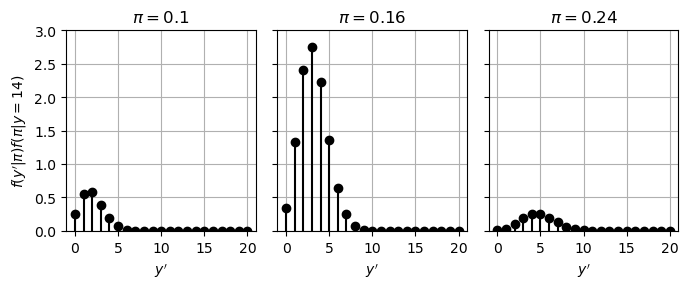

In [21]:
# Parameters
n = 20
pi_values = [0.10, 0.16, 0.24]
pi_labels = [r"$\pi = 0.1$", r"$\pi = 0.16$", r"$\pi = 0.24$"]
posterior_pdf = [beta.pdf(p, 18, 92) for p in pi_values]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(7, 3), sharey=True)

# Generate values and plots
y_vals = np.arange(0, n + 1)
for i, (pi, ax) in enumerate(zip(pi_values, axes)):
    binom_pmf = binom.pmf(y_vals, n, pi)
    weighted_vals = binom_pmf * posterior_pdf[i]
    ax.vlines(y_vals, 0, weighted_vals, colors="black")
    ax.plot(y_vals, weighted_vals, 'o', color="black")
    ax.set_title(pi_labels[i])
    ax.set_xlabel(r"$y'$")
    ax.grid(True)
    if i == 0:
        ax.set_ylabel(r"$f(y'|\pi)f(\pi|y=14)$")
    ax.set_xticks(np.arange(0, 21, 5))
    ax.set_ylim(0, 3)

# Layout and save
plt.tight_layout()
plt.show()

Putting this all together, the **posterior predictive model** of $Y'$, the number of the 20 new artists that are Gen X, takes into account both the **sampling variability** in $Y'$ and **posterior variability** in $\pi$. 

Specifically, the posterior predictive PMF calculates the overall chance of observing $Y' = y'$ across **all possible** $\pi$ from 0 to 1 by averaging across, the chance of observing $Y' = y'$ for any given $\pi$:

$$
f(y' \mid y = 14) = P(Y' = y' \mid Y = y) = \int_0^1 f(y' \mid \pi) f(\pi \mid y = 14) d\pi
$$

<div style="background-color:#e0e1e0; padding:10px; border:5px solid #737773;">

> ### Posterior predictive model  
> Let $Y'$ denote a new outcome of variable $Y$. Further, let PDF $f(y' \mid \pi)$ denote the dependence of $Y'$ on $\pi$ and posterior PDF $f(\pi \mid y)$ denote the posterior plausibility of $\pi$ given the original data $Y = y$. Then the posterior predictive model for $Y'$ has PDF:
$$
 f(y' \mid y) = \int f(y' \mid \pi) f(\pi \mid y) d\pi
$$
>
> In words, the overall chance of observing $Y' = y'$ weights the chance of observing this outcome under **any** possible $\pi$ ($f(y' \mid \pi)$) by the posterior plausibility of $\pi$ ($f(\pi \mid y)$).

</div>


An exact formula for the PMF of $Y'$ follows from some calculus (which we don't show here but is fun and we encourage you to try if you have calculus experience):

$$
f(y' \mid y = 14) = \binom{20}{y'} \frac{\Gamma(110)}{\Gamma(18)\Gamma(92)} \cdot \frac{\Gamma(18 + y') \Gamma(112 - y')}{\Gamma(130)} \quad \text{for } y' \in \left\{0, 1, \dots, 20\right\}
$$

Though this formula is unlike any we've ever seen (e.g., it's not Binomial or Poisson or anything else we’ve learned), it still specifies **what** values of $Y'$ we might observe and the **probability** of each.

For example, plugging $y' = 3$ into this formula, there's a **0.2217 posterior predictive probability** that 3 of the 20 new artists will be Gen X:

$$
f(y' = 3 \mid y = 14) = \binom{20}{3} \cdot \frac{\Gamma(110)}{\Gamma(18)\Gamma(92)} \cdot \frac{\Gamma(18 + 3)\Gamma(112 - 3)}{\Gamma(130)} = \mathbf{0.2217}
$$

The PMF formula also reflects the influence of our Beta(18, 92) posterior model for $\pi$ (through parameters 18 and 92), and hence the original prior and data, on our posterior understanding of $Y'$. That is, like any posterior operation, our posterior predictions balance information from both the prior and data.

For a look at the bigger picture, the posterior predictive PMF $f(y' \mid y = 14)$ is plotted. Though it looks similar to the model of $Y'$ when we assume that $\pi$ equals the posterior mode of 0.16, it puts relatively more weight on the smaller and larger values of $Y'$ that we might expect when $\pi$ deviates from 0.16.

All in all, though the number of the next 20 artworks that will be done by Gen X or younger artists is most likely 3, it could plausibly be anywhere between, say, 0 and 10.

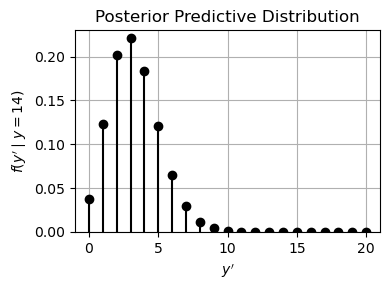

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gammaln, comb

#Parameters for Beta(18, 92)
alpha, beta_param = 18, 92
n = 20
y_vals = np.arange(0, n + 1)

# Numerically stable posterior predictive formula using log-gamma
def log_posterior_predictive(y_prime):
    log_comb = np.log(comb(n, y_prime))
    log_num = gammaln(110) + gammaln(alpha + y_prime) + gammaln(112 - y_prime)
    log_denom = gammaln(alpha) + gammaln(beta_param) + gammaln(130)
    return np.exp(log_comb + log_num - log_denom)

# Compute probabilities
probs = np.array([log_posterior_predictive(y) for y in y_vals])

# Plot
plt.figure(figsize=(4, 3))
plt.vlines(y_vals, 0, probs, colors="black")
plt.plot(y_vals, probs, 'o', color="black")
plt.xlabel(r"$y'$")
plt.ylabel(r"$f(y' \mid y = 14)$")
plt.title("Posterior Predictive Distribution")
plt.xticks(np.arange(0, 21, 5))
plt.ylim(0, 0.23)
plt.grid(True)
plt.tight_layout()
plt.show()

Finally, after building and examining the **posterior predictive model** of $Y'$, the number of the next 20 artists that will be Gen X, we might have some follow-up questions. For example, what’s the **posterior probability** that at least 5 of the 20 artists are Gen X, $P(Y' \geq 5 \mid Y = 14)$? How many of the next 20 artists do we **expect** to be Gen X, $E(Y' \mid Y = 14)$?

We can answer these questions, it’s just a bit tedious. Since the posterior predictive model for $Y'$ isn’t familiar, we can’t calculate posterior features using pre-built formulas or functions like we did for the Beta posterior model of $\pi$. Instead, we have to calculate these features from scratch.

For example, we can calculate the **posterior probability** that **at least 5** of the 20 artists are Gen X by adding up the PMF evaluated at each of the 16 $y'$ values in this range. The result of this large sum, the details of which would fill a whole page, is **0.233**:

$$
P(Y' \geq 5 \mid y = 14) = \sum_{y' = 5}^{20} f(y' \mid y = 14) \\
= f(y' = 5 \mid y = 14) + f(y' = 6 \mid y = 14) + \cdots + f(y' = 20 \mid y = 14) \\
= 0.233
$$

Similarly, though this isn’t a calculation we’ve had to do yet (and won’t do again), the **expected number** of the next 20 artists that will be Gen X can be obtained by the **posterior weighted average** of possible $Y'$ values. That is, we can add up each $y'$ value from 0 to 20 weighted by their posterior probabilities $f(y' \mid y = 14)$. The result of this large sum indicates that we should **expect roughly 3** of the 20 artists to be Gen X:

$$
E(Y' \mid y = 14) = \sum_{y'=0}^{20} y' \cdot f(y' \mid y = 14) \\
= 0 \cdot f(y' = 0 \mid y = 14) + 1 \cdot f(y' = 1 \mid y = 14) + \cdots + 20 \cdot f(y' = 20 \mid y = 14) \\
= 3.273
$$

But we don’t want to get too distracted by these types of calculations. In the following classes, we’ll never need to do something like this again. Starting next class, our models will be complicated enough so that even tedious formulas like these will be unattainable and we’ll need to rely on **simulation to approximate** posterior features.

# Bayesian benefits

We highlighted how Bayesian analyses compare to frequentist analyses. Now that we've worked through some concrete examples, let's revisit some of those ideas. As you've likely experienced, often the toughest part of a Bayesian analysis is building or simulating the posterior model. Once we have that piece in place, it's fairly straightforward to utilize this posterior for estimation, hypothesis testing, and prediction. In contrast, building up the formulas to perform the analogous frequentist calculations is often less intuitive.

We can also bask in the ease with which Bayesian results can be interpreted. In general, a **Bayesian analysis** assesses the uncertainty regarding an *unknown* parameter $\pi$ in light of observed data $Y$. For example, consider the artist study. In light of observing that $Y = 14$ of 100 sampled artists were Gen X or younger, we determined that there was an 84.9% posterior chance that Gen X representation at the entire museum, $\pi$, falls below 0.20:

$$
P(\pi < 0.20 \mid Y = 14) = 0.849.
$$

This calculation doesn’t make sense in a frequentist analysis. Flipping the script, a **frequentist analysis** assesses the uncertainty of the observed data $Y$ in light of *assumed* values of $\pi$. For example, the frequentist counterpart to the Bayesian posterior probability above is the **p-value**, the formula for which we won’t dive into here:

$$
P(Y \leq 14 \mid \pi = 0.20) = 0.08.
$$

The opposite order of the conditioning in this probability, $Y$ given $\pi$ instead of $\pi$ given $Y$, leads to a different calculation and interpretation than the Bayesian probability: if $\pi$ were only 0.20, then there’s only an 8% chance we’d have observed a sample in which at most $Y = 14$ of 100 artists were Gen X. It’s not our writing here that’s awkward, it’s the p-value.

Though it does provide us with some interesting information, the question it answers is a little less natural for the human brain: since we actually *observed* the data but *don’t know* $\pi$, it can be a mind bender to interpret a calculation that assumes the opposite. Mainly, when testing hypotheses, it’s more natural to ask “how probable is my hypothesis?” (what the Bayesian probability answers) than “how probable is my data if my hypothesis weren’t true?” (what the frequentist probability answers).

Given how frequently p-values are misinterpreted, and hence misused, they’re increasingly being de-emphasized across the entire frequentist and Bayesian spectrum.


## Exercises

**Exercise 1.** (Hypothesis tests: Part I). For parameter $\pi$, suppose you have a Beta(1, 0.8) prior model and a Beta(4, 3) posterior. You wish to test the null hypothesis that $\pi \leq 0.4$ versus the alternative that $\pi > 0.4$.

  a) What is the posterior probability for the alternative hypothesis?

  b) Calculate and interpret the posterior odds.

  c) Calculate and interpret the prior odds.

  d) Calculate and interpret the Bayes Factor.

  e) Putting this together, explain your conclusion about these hypotheses to someone who is unfamiliar with Bayesian statistics.

**Exercise 2.** (Hypothesis tests: Part II). Repeat **Exercise 1** for the following scenario. For parameter $\mu$, suppose you have a $N(10, 10^2)$ prior model, a $N(5, 3^2)$ posterior, and you wish to test $H_0 : \mu \geq 5.2$ versus $H_a : \mu < 5.2$.



**Exercise 3.** (Credible intervals: highest posterior density)

There's more than one approach to constructing a 95% credible interval. The **“middle 95%”** approach reports the range of the middle 95% of the posterior density, from the 2.5th to the 97.5th percentile. The **“highest posterior density”** approach reports the 95% of posterior values with the highest posterior densities.

**a)** Let $\lambda \mid y \sim \text{Gamma}(2, 5)$. Construct the 95% highest posterior density credible interval for $\lambda$.  
Represent this interval on a sketch of the posterior PDF. *Hint:* The sketch itself will help you identify the appropriate CI.

**b)** Repeat part a using the **middle 95%** approach.

**c)** Compare the two intervals from parts a and b. Are they the same? If not, how do they differ and which is more appropriate here?

**d)** Let $\mu \mid y \sim \mathcal{N}(-13, 2^2)$. Construct the 95% highest posterior density credible interval for $\mu$.

**e)** Repeat part **d** using the **middle 95%** approach.

**f)** Compare the two intervals from parts d and e. Are they the same? If not, why not?


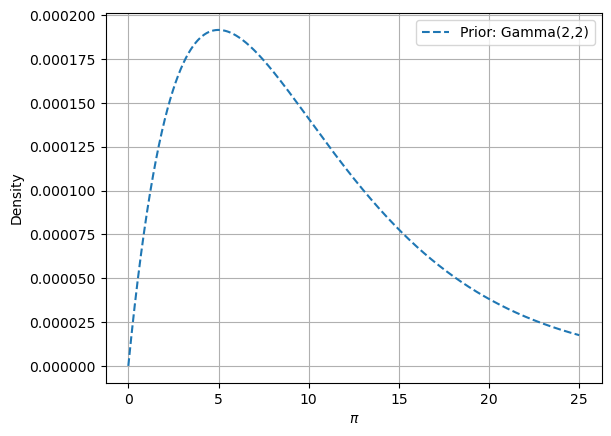

In [3]:
# solution for a) 

x = np.linspace(0, 25, 10000)
y = gamma.pdf(x, 2, scale=5)

gamma_pdf = Pmf(y,x)
gamma_pdf.normalize()
plt.plot(x, y, label='Prior: Gamma(2,2)', linestyle='--')
plt.xlabel('$\pi$')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def hpd_interval(pmf, cred_mass=0.95):
    """Compute the Highest Posterior Density (HPD) interval for a discrete Pmf."""
    if not isinstance(pmf, Pmf):
        raise TypeError("pmf variable should be from class Pmf. (from empiricaldist import Pmf)")
        return -1
        
    # Sort values by probability (descending)
    sorted_items = sorted(pmf.items(), key=lambda x: x[1], reverse=True)
    
    total = 0
    interval_values = []

    # Accumulate probabilities until we reach the credible mass
    for val, prob in sorted_items:
        interval_values.append(val)
        total += prob
        if total >= cred_mass:
            break

    # Return min and max values in the HPD set
    return min(interval_values), max(interval_values)

hpd = hpd_interval(gamma_pdf, cred_mass=0.99)
print("95% HPD interval:", hpd)

gamma_pdf.credible_interval(0.95) # solution for b)

95% HPD interval: (0.21252125212521253, 23.822382238223824)


array([ 1.18511851, 22.17721772])

**Exercise 4.** Brain health and the dangers of concussions.

Using the previous information (see Session 7, Exercises' section), so far, we had:

$$
\mu \sim N(6.5, 0.4^2)
$$

$$
Y_i \mid \mu \sim N(\mu, \sigma^2),
$$

where we assume a known standard deviation among individual hippocampal volumes, given by $\sigma = 0.5$ cm³.

Here, we asumed you already did the exercises from previous section. 

In [5]:
import pandas as pd

# Define the file path
file_path = "FootballBrain.csv"

# Load the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)
df

,Group,Hipp,LeftHipp,Years,Cogniton
0,Control,6175,2945,0,NaN
1,Control,6220,3075,0,NaN
2,Control,6360,3125,0,NaN
3,Control,6465,3160,0,NaN
4,Control,6540,3205,0,NaN
...,...,...,...,...,...
70,FBConcuss,6190,3045,14,71.0
71,FBConcuss,6420,3155,13,NaN
72,FBConcuss,6445,3200,15,88.0
73,FBConcuss,6635,3255,9,NaN


A dataset with 75 observations on the following 5 variables.

| **Variable**  | **Description**  |
|--------------|----------------|
| **Group**   | `Control` = no football, `FBNoConcuss` = football player but no concussions, or `FBConcuss` = football player with concussion history |
| **Hipp**    | Total hippocampus volume, in microL |
| **LeftHipp** | Left hippocampus volume, in microL |
| **Years**   | Number of years playing football |
| **Cognition** | Cognitive testing composite reaction time score, given as a percentile |


### Prior model

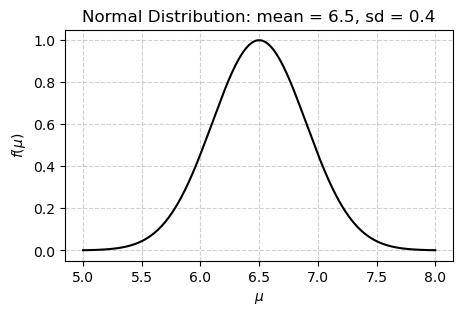

In [38]:
x = np.linspace(5, 8, 5000)
mu_prior = 6.5
std_prior = 0.4

prior = norm.pdf(x, mu_prior, std_prior)

# Plot the prior model
plt.figure(figsize=(5, 3))
plt.plot(x, prior, color='black')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$f(\mu)$')
plt.grid(True, linestyle='--', alpha=0.6)
plt.title("Normal Distribution: mean = 6.5, sd = 0.4")
plt.show()


### Data models

### Posteriors

Using the Normal-Normal model

$$
Y_i | \mu \sim N(\mu, \sigma^2)
$$

$$
\mu \sim N(\theta, \tau^2)
$$

$$
\mu \mid \vec{y} \sim N \left( \theta \frac{\sigma^2}{n\tau^2 + \sigma^2} + \bar{y} \frac{n\tau^2}{n\tau^2 + \sigma^2}, \frac{\tau^2 \sigma^2}{n\tau^2 + \sigma^2} \right).
$$

### Posterior for control group

### Posterior for Football group

### Posteriors toghether

>? Given an individual with hippocampal volume $6253 \pm 350$ microL, determine the probability that this person plays football.

That's a wierd question for a Bayesian analysis. However, can we say something about the individual?

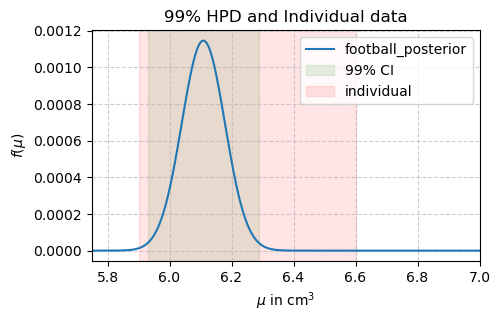

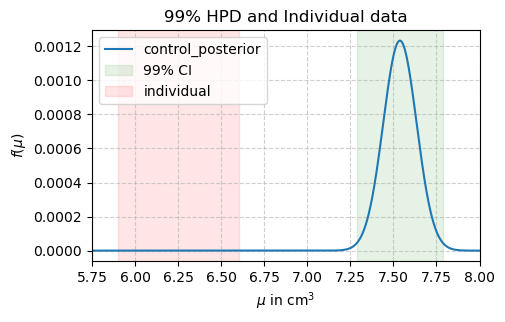

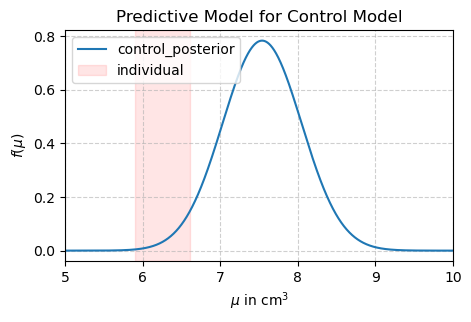

0.026776627749822958


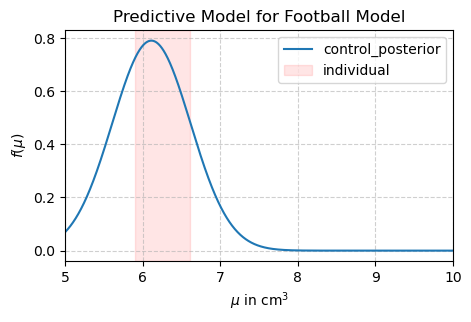

0.47540905659954047
